# Exercise B01:  Introduction to distributions and basic sampling in CUQIpy

This notebooks describes basic usage of distributions in CUQIpy, including visualizing their probability density function (PDF) and cumulative distribution function (CDF), and generating samples. Then conditional distributions are demonstrated along with the creation of user-defined distributions. Finally, the notebook describes how distributions can be equipped with geometry to represent random variables in nontrivial spaces.

## Learning objectives of this notebook:
Going through this notebook, you will see how to:
- Set up random variables following uni- and multi-variate distributions in CUQIpy.
- Generate samples from distributions and use CUQIpy tools to inspect visually.
- Set up conditional distributions in CUQIpy - simple and using lambda functions.
- ★ Create a user-defined distribution from a logpdf function.
- ★ Explain the use of Geometry in distributions and samples.


## Table of contents: 
* [1. Normal distribution (univariate)](#Normal)
* [2. Multivariate distributions](#Multivariate)
* [3. Conditional distributions ](#Conditional)
* [4. User-defined distributions ★](#Userdefined)
* [5. Geometry in distributions and samples ★](#Geometry)

★ Indicates optional section.

## References
[1] *Bardsley, Johnathan. 2018. Computational Uncertainty Quantification for Inverse Problems. SIAM, Society for Industrial and Applied Mathematics.*




First we need to import any Python packages needed, here NumPy for array computations and Matplotlib for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We import CUQIpy. In the other notebooks we may import upfront the specific tools we need, like `from cuqi.distribution import Gaussian` to get the Gaussian distribution from CUQIpy's distribution module. We now simply import the complete package and then specify the complete name such as `cuqi.distribution.Gaussian` when using it. Both approaches are fine, each with pros and cons.

In [2]:
import cuqi

## 1. Normal distribution  (univariate)  <a class="anchor" id="Normal"></a> 

The first thing we can do is to define a simple normal distribution of a single variable, e.g.,

$$ x \sim \mathrm{Normal}(0,1^2) $$

This is done using the following syntax:

In [3]:
x = cuqi.distribution.Normal(mean=0, std=1)

More information on the distribution can be found in the [CUQIpy API documentation](https://cuqi-dtu.github.io/CUQIpy/api/index.html).

Once created, we can print the distribution object, and its dimension and name:

In [4]:
print(x)
print(x.dim)
print(x.name)

CUQI Normal.
1
x


Note that the name is inferred automatically from the assignment statement `x = cuqi.distribution.Normal(mean=0, std=1)`. Since the distribution was assigned to the variable `x`, by default, the distribution name will be `x`. One can specify a different name by explicitly passing the `name` argument, e.g. `x = cuqi.distribution.Normal(mean=0, std=1, name='x1')`. We can query other information about this distribution such as its mean and standard deviation:

In [5]:
print(x.mean)
print(x.std)

0
1


Distributions in CUQIpy have commonly used methods that one might expect like *pdf*, *logpdf*, *cdf*, etc. For example we can evaluate the CDF at 0, which should be 0.5, since the pdf is symmetric about 0:

In [6]:
x.cdf(0)

0.5

We can evaluate and plot the CDF on an interval by evaluating the CDF on a grid:

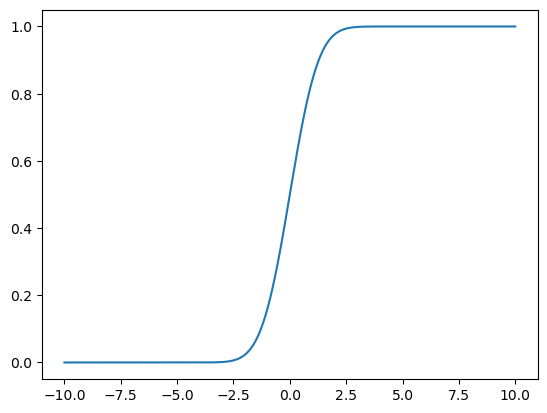

In [7]:
grid = np.linspace(-10, 10, 1001)
cdf_vals = np.zeros(grid.shape)
for k in range(len(grid)):
    cdf_vals[k] = x.cdf(grid[k])
plt.plot(grid, cdf_vals)

Alternative more compact form using python's list comprehension:

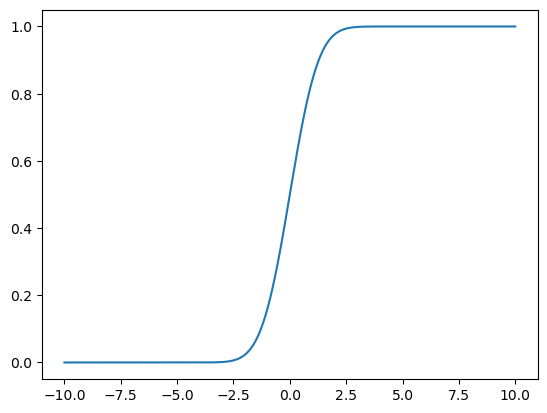

In [8]:
plt.plot(grid, [x.cdf(node_k) for node_k in grid])

CUQIpy distributions also have `sample` method which returns one or more samples from the distribution as a `CUQIarray`:

In [9]:
x.sample()

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(1,)

Parameters:
 True

Array:
CUQIarray(-0.49525778)

By default a single sample is returned. More samples can easily be requested:

In [10]:
x_samples = x.sample(10000)
type(x_samples)

cuqi.samples._samples.Samples

When more than one sample is generated, a CUQIpy `Samples` object is returned. This is essentially an array in which each column contains one sample, and further equipped with a number of methods for computing samples statistics, diagnostics and plotting.

For example, one can make a "chain plot", i.e., the sampled values of selected parameter(s) of interest. Here we have a single parameter and with Python being zero-indexed, we specify this parameter, the 0-th element of `x`, as follows:

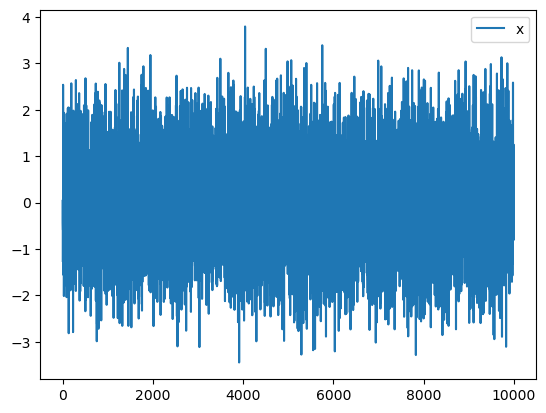

In [11]:
x_samples.plot_chain(0)

Another possibility is a histogram of the parameter chain: (The keyword arguments are passed directly to the underlying matplotlib `hist` function for full control). Again, we specify 0 as the element to look at the chain for:

<BarContainer object of 100 artists>

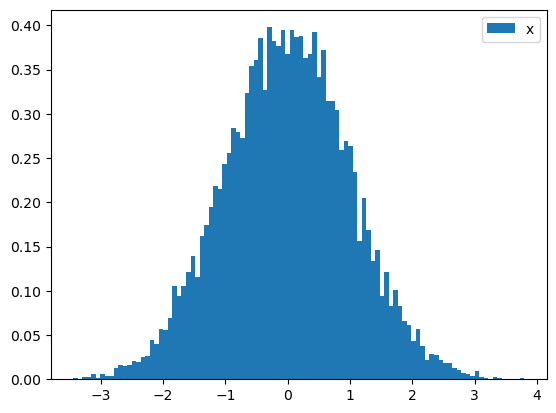

In [12]:
x_samples.hist_chain(0, bins=100, density=True)

CUQIpy has integrated support for common statistical plots with the [ArviZ library](https://arviz-devs.github.io/arviz/), for example a "trace plot" combines the previous two plots, where the histogram is replaced by a kernel density estimate (KDE).

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

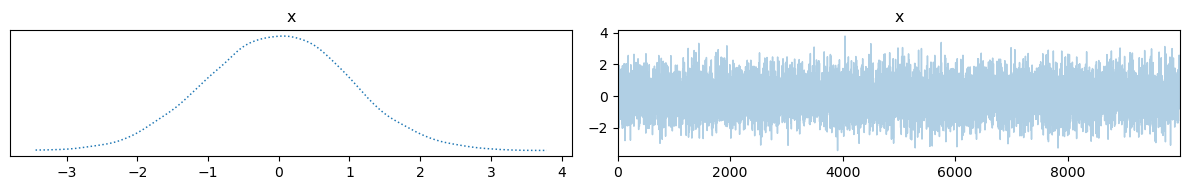

In [13]:
x_samples.plot_trace()

#### Try yourself (optional):  
 - Create a new random variable `r` following a normal distribution with mean 2 and standard deviation 3.
 - Generate 100 samples and display a histogram.
 - Compare with the theoretical distribution by plotting the probability density function of `r` on top of the histogram.
 - Increase the number of samples and (hopefully) see the histogram approach the theoretical PDF.

In [ ]:
# Type code here:



## 2. Multivariate distributions <a class="anchor" id="Multivariate"></a> 

CUQIpy currently implements a number of multivariate distributions in the `cuqi.distribution` module:

In [14]:
[dist for dist in dir(cuqi.distribution) if not dist.startswith('_')]

['Beta',
 'CMRF',
 'Cauchy',
 'Distribution',
 'DistributionGallery',
 'GMRF',
 'Gamma',
 'Gaussian',
 'InverseGamma',
 'JointDistribution',
 'JointGaussianSqrtPrec',
 'LMRF',
 'Laplace',
 'Lognormal',
 'ModifiedHalfNormal',
 'MultipleLikelihoodPosterior',
 'Normal',
 'Posterior',
 'SmoothedLaplace',
 'Uniform',
 'UserDefinedDistribution']

and more can easily be added when needed.


As a demonstration, we specify here a 4-element random variable `y` following a Gaussian distribution with independent elements:

$$\mathbf{y} \sim \mathrm{Gaussian}(\mu,\mathrm{diag}(\sigma^2)) \quad \text{for} \quad \mu = [5, 3, 1, 0]^T \quad \text{and} \quad \sigma = [1,2,3, 0.5]$$

In [15]:
true_mu = np.array([5, 3, 1, 0])
true_sigma = np.array([1, 2, 3, 0.5])
y = cuqi.distribution.Gaussian(mean=true_mu, cov=true_sigma**2)

As before, we can take a look at the distribution by printing it and its dimension:

In [16]:
print(y)
print(y.dim)
print(y.name)

CUQI Gaussian.
4
y


as well as its mean

In [17]:
print(y.mean)

[5 3 1 0]


and its diagonal covariance matrix (represented as a 1D array of the diagonal values):

In [18]:
print(y.cov)

[1.   4.   9.   0.25]


We generate a single sample, which is represented by a 4-element `CUQIarray`:

In [19]:
y.sample()

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(4,)

Parameters:
 True

Array:
CUQIarray([ 6.17568447,  5.32011875, -0.21407315,  0.01387213])

If we ask for more than one sample, say 1000, we get a `Samples` object with 1000 columns each holding a 4-element sample:

In [20]:
y_samples = y.sample(1000)
print(y_samples)
y_samples.shape

CUQIpy Samples:
---------------

Ns (number of samples):
 1000

Geometry:
 _DefaultGeometry1D(4,)

Shape:
 (4, 1000)

Samples:
 [[ 4.06797496  5.83980723  3.56479027 ...  6.93555219  5.05162432
   4.02302041]
 [ 6.4805364   3.53488904  4.3542775  ... -0.763823    2.30032133
   5.99001114]
 [ 3.31203046  1.02313525 -1.09864272 ...  5.42231944  2.68826281
   8.55896207]
 [ 0.0701887  -0.40178983  0.22214159 ...  0.22485201 -0.18266602
  -0.27714569]]




(4, 1000)

We can plot chains of a few of these variable samples, here we pick element 2 and 0:

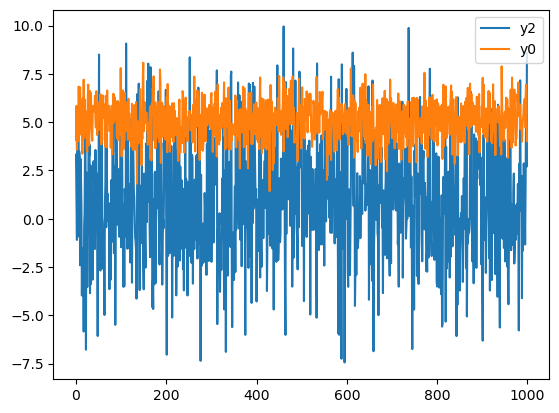

In [21]:
y_samples.plot_chain([2, 0])

We can as well plot a few samples of `y`, each individual containing 4 elements:

Plotting 5 randomly selected samples


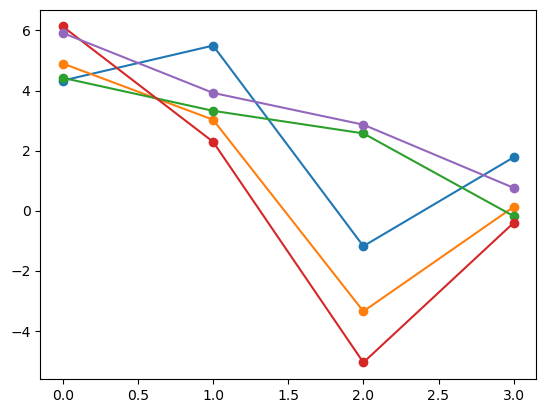

In [23]:
y_samples.plot(marker='o');

By default 5 random samples are plotted, but we can also specify indices of specific samples we wish to plot, like the 1st and 3rd elements:

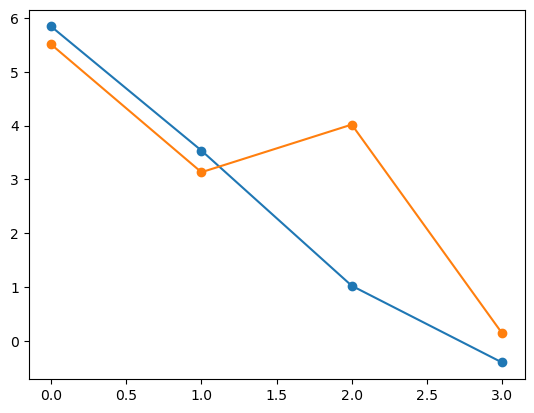

In [25]:
y_samples.plot([1,3],marker='o');

Another option for inspecting samples is a "violin plot", which displays the median as a white circle, the interquartile range, along with the density/histogram on either side:

array([<Axes: title={'center': 'y0'}>, <Axes: title={'center': 'y1'}>,
       <Axes: title={'center': 'y2'}>, <Axes: title={'center': 'y3'}>],
      dtype=object)

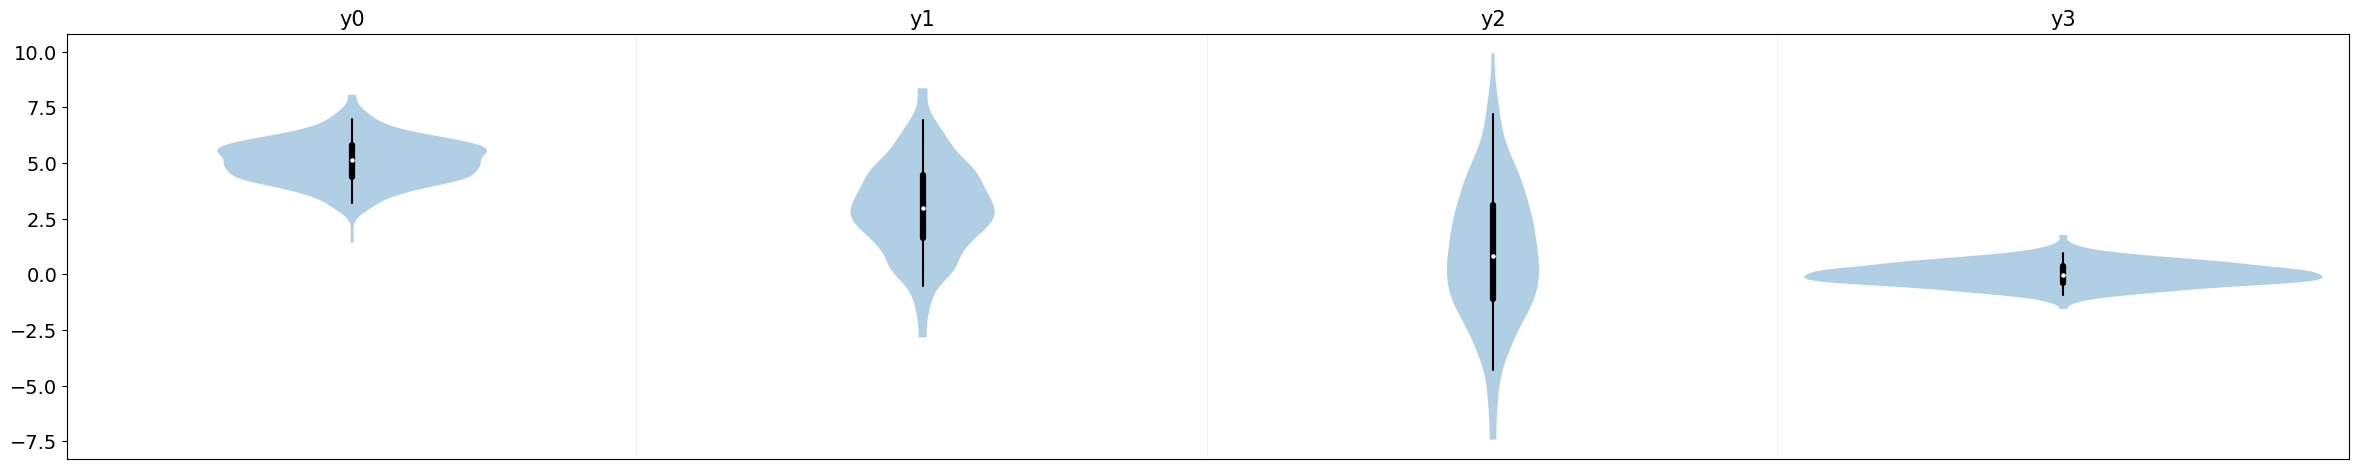

In [26]:
y_samples.plot_violin()

We can also plot the sample mean and compare with the true mean of the distribution:

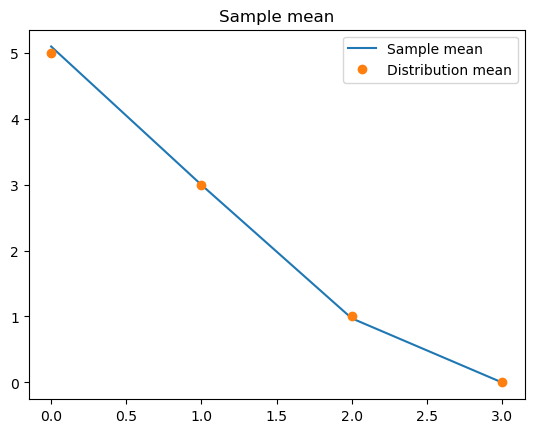

In [27]:
y_samples.plot_mean(label="Sample mean")
plt.plot(y.mean, 'o', label="Distribution mean")
plt.legend()

and sample standard deviation along with the true standard deviations of the distribution which we obtain as the square-root of the diagonal of the covariance matrix:

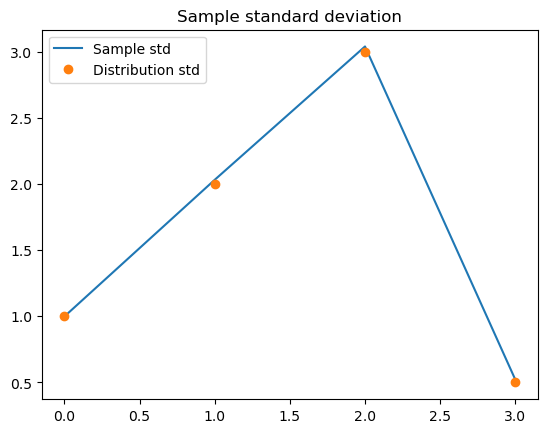

In [28]:
y_samples.plot_std(label="Sample std")
plt.plot(np.sqrt(y.cov), 'o', label="Distribution std")
plt.legend()

#### Try yourself (optional):  
 - Plot mean with 95% credibility interval, hint: `help(y_samples.plot_ci)`.
 - When plotting credibility interval with ``plot_ci``, plot also the true mean using the `exact` keyword argument.
 - Reduce and increase the number of samples and study the effect on the mean and credibility interval.
 - Try also 50% and 99% credibility intervals.

In [ ]:
# Type code here:


## 3. Conditional distributions <a class="anchor" id="Conditional"></a> 

CUQIpy also support conditional probability distributions, which are probability distributions that are defined conditionally on the value of one or more other random variables. 

In CUQIpy, defining conditional distributions is simple. Assume we are interested in defining the Normal distribution conditioned on a random variable representing the standard deviation, e.g.

$$ z \mid \mathrm{std} \sim \mathrm{Normal}(0,\mathrm{std}^2) $$

This can simply be achieved by *omitting* the keyword argument for the standard deviation, when defining the distribution, as shown in the following code

In [29]:
z = cuqi.distribution.Normal(mean=0)

Printing it will tell us that the variable `std` has not been specified, i.e., it is a *conditioning variable*:

In [30]:
print(z)

CUQI Normal. Conditioning variables ['std'].


Because $z$ is a conditional distribution, we cannot evaluate the logpdf or sample it directly without specifying the value of the conditioning variable (the standard deviation in this case). Hence this code will fail to run:

In [31]:
# This code will give an error so we wrap it in a try/except block and print the error
try:
    z.sample()
except Exception as e:
    print(e)

Cannot sample from conditional distribution. Missing conditioning variables: ['std']


To specify the conditioning variable we use the "call" syntax, i.e., `z(std=2)` to set the value of the standard deviation in the conditional distribution as shown below.

In [32]:
z(std=2).sample()

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(1,)

Parameters:
 True

Array:
CUQIarray(1.82777583)

In fact, conditioning creates a new *unconditional* distribution. Here printing reveals that it does not have any conditioning variables:

In [33]:
z_given_std = z(std=2)
print(z_given_std)

CUQI Normal.


We expect we can then sample it directly, which is confirmed:

In [34]:
z_given_std.sample()

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(1,)

Parameters:
 True

Array:
CUQIarray(0.81081765)

In general, one may need more flexibility than simply conditioning directly on the attributes of the distribution. Let us assume we want to define a distribution that is conditional on the variance - denoted $d$ - rather than the standard deviation of the normal distribution, i.e.

$$ w \mid d \sim \mathrm{Normal}(0,d). $$

In CUQIpy this can be achieved through *lambda* functions. A lambda function is the Python equivalent of a MATLAB anonymous function, i.e. a function defined in a single line with the following syntax for an example function the simply sums two input arguments:

In [35]:
myfun = lambda v1, v2: v1+v2

In [36]:
myfun(5,7)

12

We can pass a lambda function directly as an argument to a CUQIpy distribution, e.g.,

In [37]:
w = cuqi.distribution.Normal(mean=0, std=lambda d: np.sqrt(d))
print(w)

CUQI Normal. Conditioning variables ['d'].


where we see that `d` is now the conditioning variable instead of `std` as before.

We can then pass a value for `d` to condition on, which allows us to sample from the now fully specified distribution:

In [38]:
w(d=2).sample()

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(1,)

Parameters:
 True

Array:
CUQIarray(-1.03242517)

What actually happens behind the scenes is that writing `w(d=2)` defined a new CUQIpy distribution where the standard deviation is set by evaluating the lambda function. This can be seen by storing the new distribution as follows.

In [39]:
w_given_d = w(d=2)
w_given_d.std

1.4142135623730951

This framework allows for a lot of flexibility in defining conditional distributions. For example we can define lambda functions for all attributes (here the mean and the standard deviation):

In [40]:
#Functions for mean and std with various (shared) inputs
mean = lambda sigma, gamma: sigma+gamma
std  = lambda delta, gamma: np.sqrt(delta+gamma)

u = cuqi.distribution.Normal(mean, std)
print(u)

CUQI Normal. Conditioning variables ['sigma', 'gamma', 'delta'].


The three variable names `sigma`, `gamma` and `delta` used to define the two lambda functions for the mean and standard deviation are now the conditioning variables of the conditional distribution `u`.

By providing values for all three variables we obtain a fully specified distribution

In [41]:
u_given_all = u(sigma=3, delta=5, gamma=-2)
print(u_given_all)

CUQI Normal.


that we can sample:

In [42]:
u_given_all.sample()

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(1,)

Parameters:
 True

Array:
CUQIarray(0.94686525)

Conditional distributions play a major role when specifying Bayesian inverse problems in CUQIpy and in particular those problems that include Bayesian hierarchical models where some random variables depend on other random variables. We revisit this in later notebooks.

## 4. User-defined distributions ★ <a class="anchor" id="Userdefined"></a> 

In addition to the distributions provided by CUQIpy, there is also the possibility for users to specify new distributions. One option is to write their own class in the same style as existing distributions such as the Cauchy distribution (see code here: [Cauchy](https://github.com/CUQI-DTU/CUQIpy/blob/main/cuqi/distribution/_cauchy.py)).

Another option is to specify a user-defined distribution, which is convenient if one, for example, only wishes to evaluate the logpdf.

The example below demonstrates how to manually specify a normal distribution through a lambda function for the logpdf and compare it to the normal distribution defined in the beginning of this notebook.

We specify variables for the mean and the standard deviation and specify the lambda function for the logpdf. 

In [43]:
mu1 = 0
std1 = 1

logpdf_func = lambda xx: -np.log(std1*np.sqrt(2*np.pi))-0.5*((xx-mu1)/std1)**2

To set up the user-defined distribution, we need to specify the logpdf as well as its dimension (number of variables) since that cannot be automatically inferred from the lambda function:

In [44]:
x_user = cuqi.distribution.UserDefinedDistribution(dim=1, logpdf_func=logpdf_func)

We can now evalute the logpdf, as well as the pdf:

In [45]:
print(x_user.logpdf(0))
print(x_user.pdf(0))

-0.9189385332046727
0.3989422804014327


We can compare this with the normal distribution from the beginning of the notebook and observe that their pdfs agree:

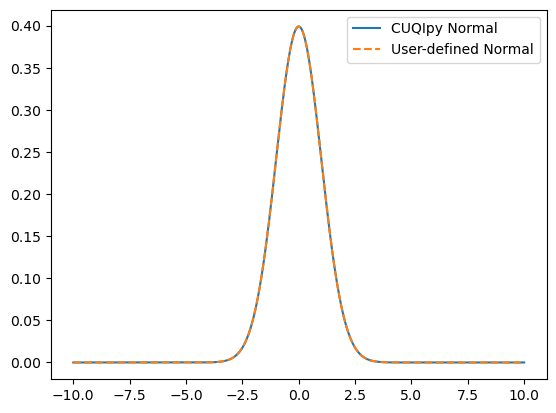

In [46]:
plt.plot(grid, [x.pdf(node_k) for node_k in grid], label='CUQIpy Normal')
plt.plot(grid, [x_user.pdf(node_k) for node_k in grid], '--', label='User-defined Normal')
plt.legend()

We cannot sample the user-defined distribution because we have only provided the logpdf:

In [47]:
try:
    x_user.sample()
except Exception as e:
    print(e)

sample_func is not defined. Sampling can be performed by passing the density to a sampler from the 'sampler' module.


We can equip the user-defined distribution with a sample_func which specified how to sample (it is up to the user to ensure consistency between logpdf and sample_func):

In [48]:
x_user.sample_func = lambda : np.array(mu1 + std1*np.random.randn())

In [49]:
x_user.sample()

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(1,)

Parameters:
 True

Array:
CUQIarray(-0.52929995)

We can compare the samples obtained from the original normal distribution and the user-defined:

In [50]:
x_samples = x.sample(10000)

In [51]:
x_user_samples = x_user.sample(10000)

We plot their histograms and note that they appear similar:

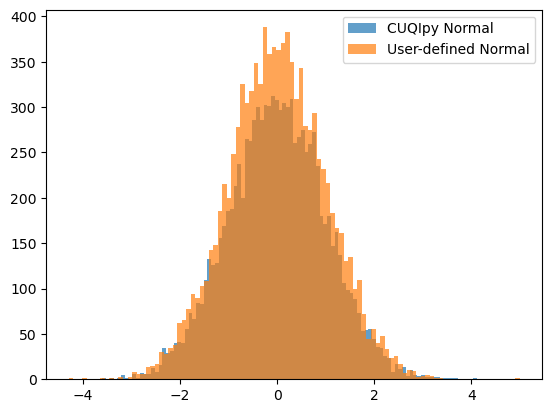

In [55]:
x_samples.hist_chain(0,bins=100)
x_user_samples.hist_chain(0,bins=100)
plt.legend(['CUQIpy Normal', 'User-defined Normal'])

## 5. Geometry in distributions and samples ★ <a class="anchor" id="Geometry"></a> 

A single sample from a distribution (in vector form) can be interpreted in various ways. It can be, for example, a vector of function values at 1D or 2D grid points, an image, a vector of expansion coefficients, or a collection of variables, e.g. the temperature measurement at four cities: A, B, C, and D. 

In CUQIpy, the [`cuqi.geometry`](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.geometry.html) module provides classes for different representations of a vector, e.g `Continuous1D`, `Continuous2D`, `Image2D`, and `Discrete`.     


Here we explore geometry assignment for `Distributions`, `Samples` and `CUQIarray`. First let us create 1000 samples from the 4-element distribution $y$ we created earlier:

In [56]:
y_samples = y.sample(1000)

If no geometry is provided by the user, when creating a `Distribution` for example, CUQIpy will assign `_DefaultGeometry` (trivial geometry) to the distribution and the `Samples` produced from it.

In [57]:
print(y.geometry)
print(y_samples.geometry)

_DefaultGeometry1D(4,)
_DefaultGeometry1D(4,)


As we saw, samples are plotted with line plot by default, which is due to how the `_DefaultGeometry` interprets the samples. 

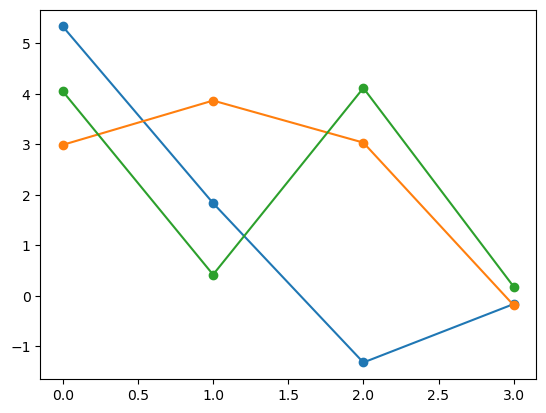

In [59]:
y_samples.plot([100,200,300], marker='o')

We may equip the distribution with a different geometry, either when creating it, or afterwards. Let us for example assign an `Image2D` geometry to the distribution `y`. First we create the `Image2D` geometry and we assume the shape of the image is $2\times2$:

In [60]:
geom_image = cuqi.geometry.Image2D((2,2))
print(geom_image)

Image2D(4,)


We can check the number of parameters (parameter dimension) of the geometry:

In [61]:
geom_image.par_dim

4

We can also check the shape of its representation (size of the image in this case) using the property `fun_shape`:

In [62]:
geom_image.fun_shape

(2, 2)

Now we equip the distribution `y` with this `Image2D` geometry.

In [63]:
y.geometry = geom_image

Check the geometry of `y`:

In [64]:
y.geometry

Image2D(4,)

With this distribution set up, we are ready to generate some samples

In [65]:
# call method to sample
y_samples = y.sample(50)

We can check that we have produced 50 samples, each of size 4:

In [68]:
y_samples.shape

(4, 50)

We plot a couple of samples:

Plotting 5 randomly selected samples


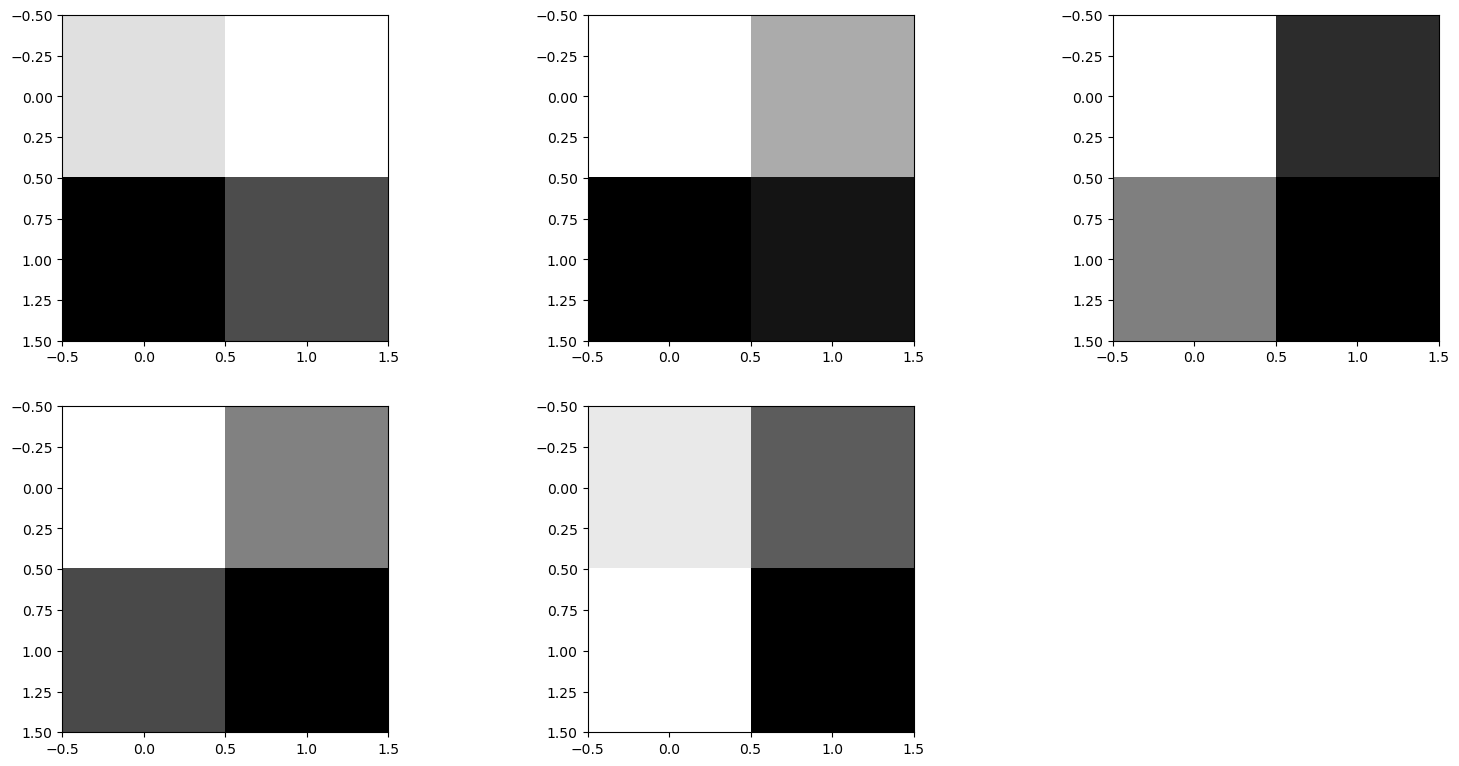

In [69]:
y_samples.plot()   

What if the 4 parameters in samples have a different meaning? For example, the four parameters might represent labelled quantities such as temperature measurement at four cities A, B, C, D. In this case, we can use a `Discrete` geometry:

In [70]:
geom_discrete = cuqi.geometry.Discrete(['Temperature A', 'Temperature B', 'Temperature C', 'Temperature D'])
print(geom_discrete)

Discrete(4,)


We can update the distribution's geometry and generate some new samples:

In [71]:
y.geometry = geom_discrete

In [72]:
y_samples = y.sample(100)

The samples will now know about their new `Discrete` geometry and the plotting style will be changed:

Plotting 5 randomly selected samples


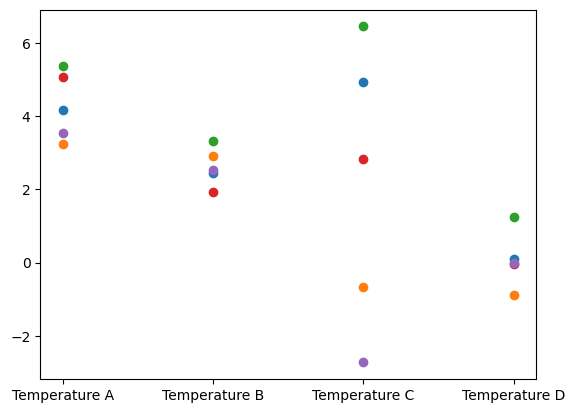

In [75]:
y_samples.plot();

The credibility interval plot style is also updated to show errorbars for the `Discrete` geometry:

 <ErrorbarContainer object of 3 artists>]

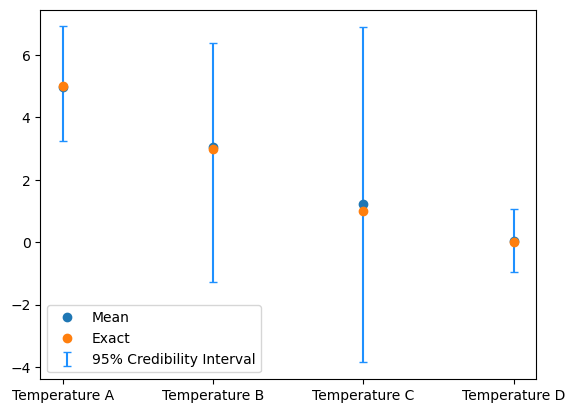

In [76]:
y_samples.plot_ci(95, exact=true_mu)

And similarly, in the chain plot, the legend reflects the particular labels:

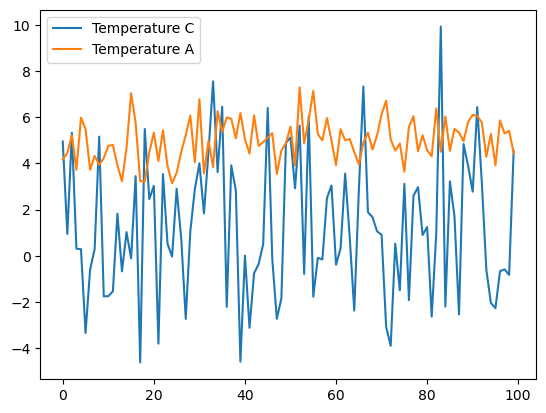

In [77]:
y_samples.plot_chain([2,0])

Geometries can also be specified for `CUQIarray`, the basic array structure in CUQIpy. Let us create a `CUQIarray` object with four parameters as follows: 

In [78]:
q = cuqi.array.CUQIarray([1,5,6,0])

We look at the geometry property 

In [79]:
q.geometry

_DefaultGeometry1D(4,)

And then let us plot our variable `q`:

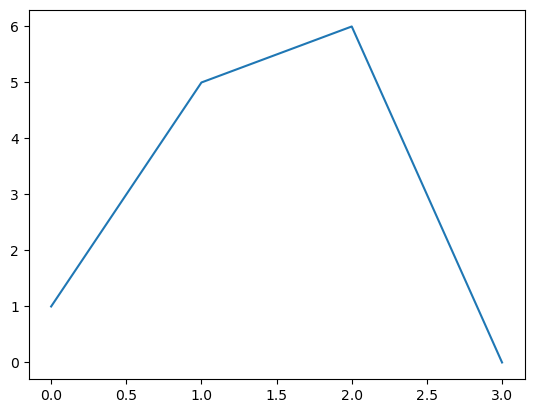

In [80]:
q.plot()

We now choose a different interpretation for the variable `q` by changing its geometry to, for example, the `Image2D` geometry we created, and then we plot:

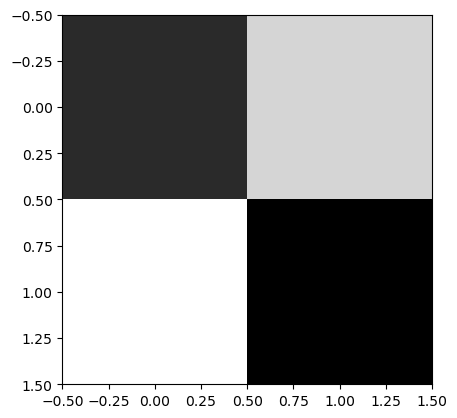

In [81]:
q.geometry = geom_image
q.plot()

Finally we set the `Discrete` geometry we created as the geometry for `q` and plot: 

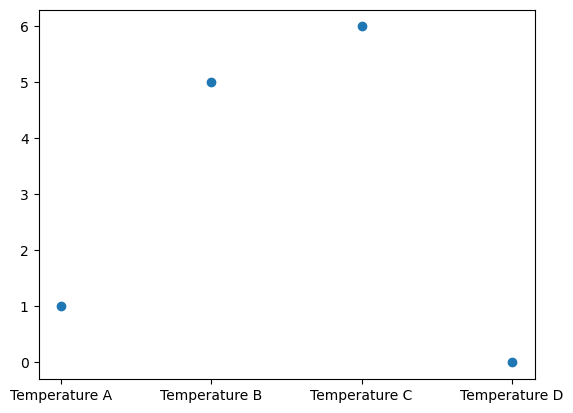

In [82]:
q.geometry = geom_discrete
q.plot()

#### Try yourself (optional): 
 - In CUQIpy, we have `StepExpansion` geometry for which the parameters represent expansion coefficients for equidistance-step basis functions. You can read more about `StepExpansion` by typing `help(cuqi.geometry.StepExpansion)` in a the code cell below or by looking at the [documentation of `StepExpansion`](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.geometry/cuqi.geometry.StepExpansion.html)
    - To create a `StepExpansion` geometry, you will need a grid on which the StepExpansion is represented. For example, you may create a uniform grid of 20 nodes on the interval $[0,1]$, including the end points (hint: you can use `np.linspace` method).
    - Create a `StepExpansion` geometry using the grid you just created and set the number of steps to be 4.
    - Set the geometry of the `q` to be the `StepExpansion` geometry you just created.
    - Plot q using `q.plot()`.

In [ ]:
# Type code here:

